In [138]:
import torch
from torch.optim import Adam

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import PIL.Image as Image

from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

from torchvision import transforms
from torchvision import datasets
import time

In [3]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [4]:
directory = 'lrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))


Number of images 1442


In [5]:
class UNLRG(data.Dataset):
    def __init__(self, images, transform=None):
        self.data = images
        self.data_len = len(self.data)
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
#                 transforms.RandomResizedCrop((128,128),(.5,1)),
                transforms.ToTensor()])
        else : self.transform = transform

#     def __load_data
            
    def __getitem__(self, index):
        index = index % self.data_len
        np_arr = self.data[index, :]
        ## reshape np_arr to 28x28
        np_arr = np_arr.reshape(128, 128)

        ## convert to PIL-image
        img = Image.fromarray((np_arr*255).astype('uint8'))

        #apply the transformations and return tensors
        return self.transform(img)
    def __len__(self):
        return self.data_len * 10
    def __repr__(self) -> str:
        return 'unLRG dataset'

In [6]:
images = np.array(images)
dataset = UNLRG(images)

In [7]:
np.max(images)

0.9992211085045711

In [122]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d( 1,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  1, 3, 2, 1, 1),
#             nn.ReLU()
        )
        
        self.lin = nn.Linear(512, 2)
        self.nil = nn.Linear(2, 512)
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 32*4*4)
        return self.lin(x)
    
    def decode(self, x):
        x = self.nil(x)
        x = x.view(-1, 32, 4, 4)
        decoded = self.decoder(x)
        return torch.sigmoid(decoded)
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded  = self.decode(encoded)
        return decoded

In [123]:
data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False)
sample = iter(data_loader).next()

In [124]:
device = 'cuda'

cae = CAE().to(device)
optimizer = Adam(cae.parameters(), lr=0.001)
loss_fnc = nn.BCELoss(reduction='sum').to(device)
cae(sample.cuda()).shape

torch.Size([64, 1, 128, 128])

In [125]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    dt_cnt = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        dt_cnt += len(data)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        # BCE Loss
        loss = loss_fnc(output, data)
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:4d} [{:5d}/{:5d} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, dt_cnt, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/(len(data)))
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [126]:
for epoch in range(1, 31):
    start = time.time()
    s = train_step(cae, 'cuda' ,data_loader, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))

Train Epoch:    1 [ 14420/14420 (100%)]	Loss: 268.920557	Time 11.84s
Train Epoch:    2 [ 14420/14420 (100%)]	Loss: 250.953271	Time 11.82s
Train Epoch:    3 [ 14420/14420 (100%)]	Loss: 239.519482	Time 11.86s
Train Epoch:    4 [ 14420/14420 (100%)]	Loss: 236.665527	Time 11.80s
Train Epoch:    5 [ 14420/14420 (100%)]	Loss: 225.792749	Time 11.87s
Train Epoch:    6 [ 14420/14420 (100%)]	Loss: 220.680566	Time 11.89s
Train Epoch:    7 [ 14420/14420 (100%)]	Loss: 225.546436	Time 12.09s
Train Epoch:    8 [ 14420/14420 (100%)]	Loss: 221.705566	Time 11.99s
Train Epoch:    9 [ 14420/14420 (100%)]	Loss: 219.918311	Time 12.20s
Train Epoch:   10 [ 14420/14420 (100%)]	Loss: 217.532056	Time 11.89s
Train Epoch:   11 [ 14420/14420 (100%)]	Loss: 220.625049	Time 11.77s
Train Epoch:   12 [ 14420/14420 (100%)]	Loss: 223.915161	Time 11.73s
Train Epoch:   13 [ 14420/14420 (100%)]	Loss: 220.061890	Time 11.81s
Train Epoch:   14 [ 14420/14420 (100%)]	Loss: 218.922852	Time 11.77s
Train Epoch:   15 [ 14420/14420 (1

In [127]:
sample = iter(data_loader).next()

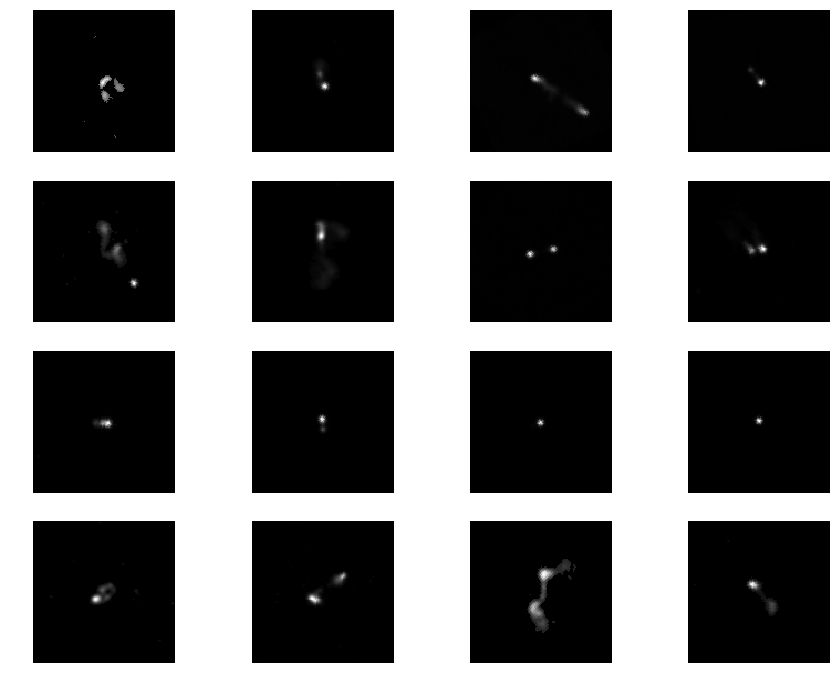

In [128]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(sample[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

In [129]:
with torch.no_grad():
    e     = cae.encode(sample.to(device))
    recon = cae.decode(e).cpu()

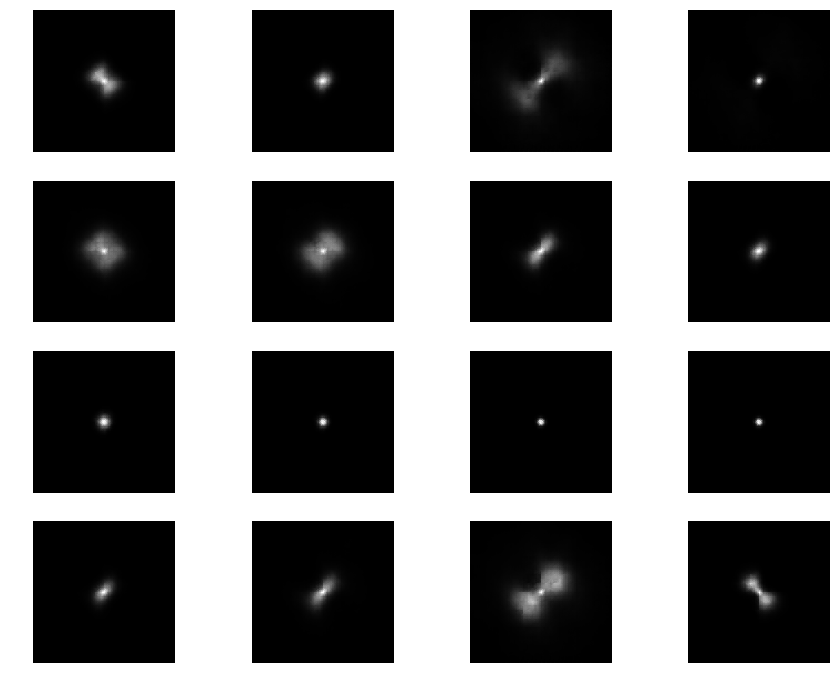

In [130]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(recon[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

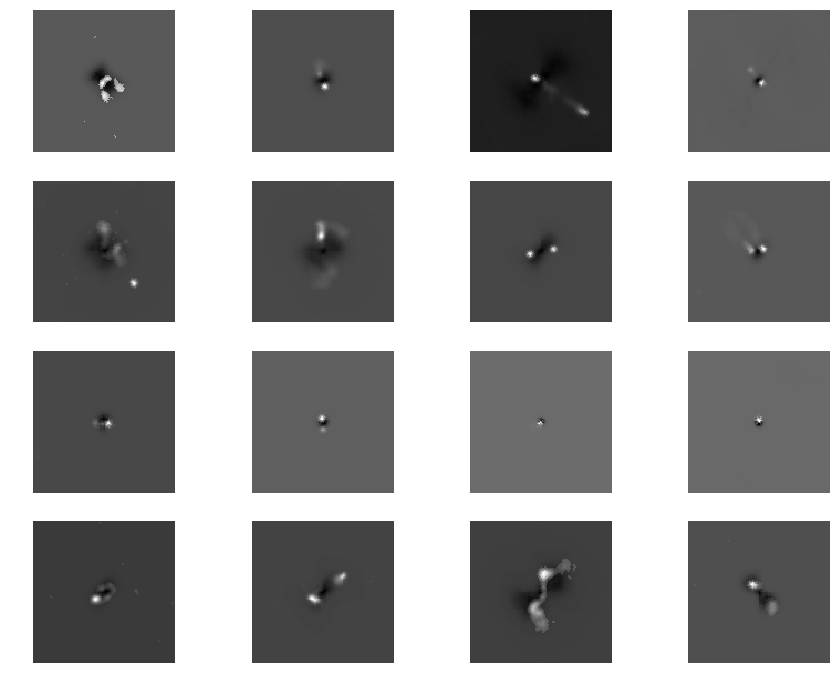

In [131]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        o, r = sample[i*4 + j][0], recon[i*4 + j][0] 
        ax[i][j].imshow(o - r, cmap='gray')
        ax[i][j].axis('off')

In [196]:
torch.save(cae, 'cae_model_2')
# cae = torch.load('cae_model')
# cae.eval()

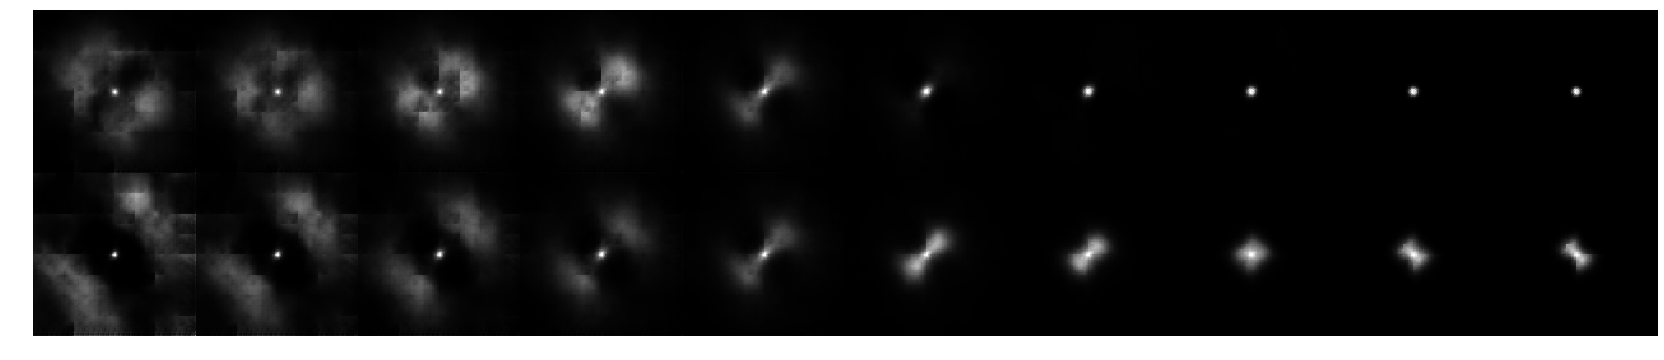

In [181]:
a = 2
s = sample[a:a+1]
r = 10
nimg = r * 2
k = 1
m = 1


plt.figure(figsize=(29.1, 6))
gs1 = gridspec.GridSpec(2, r)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

for i in range(2):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = cae.encode(s.to(device))[0]
            v = e[i]
            nv = -4*k + v + k*j
            e[i] = nv
            d = cae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

plt.show()

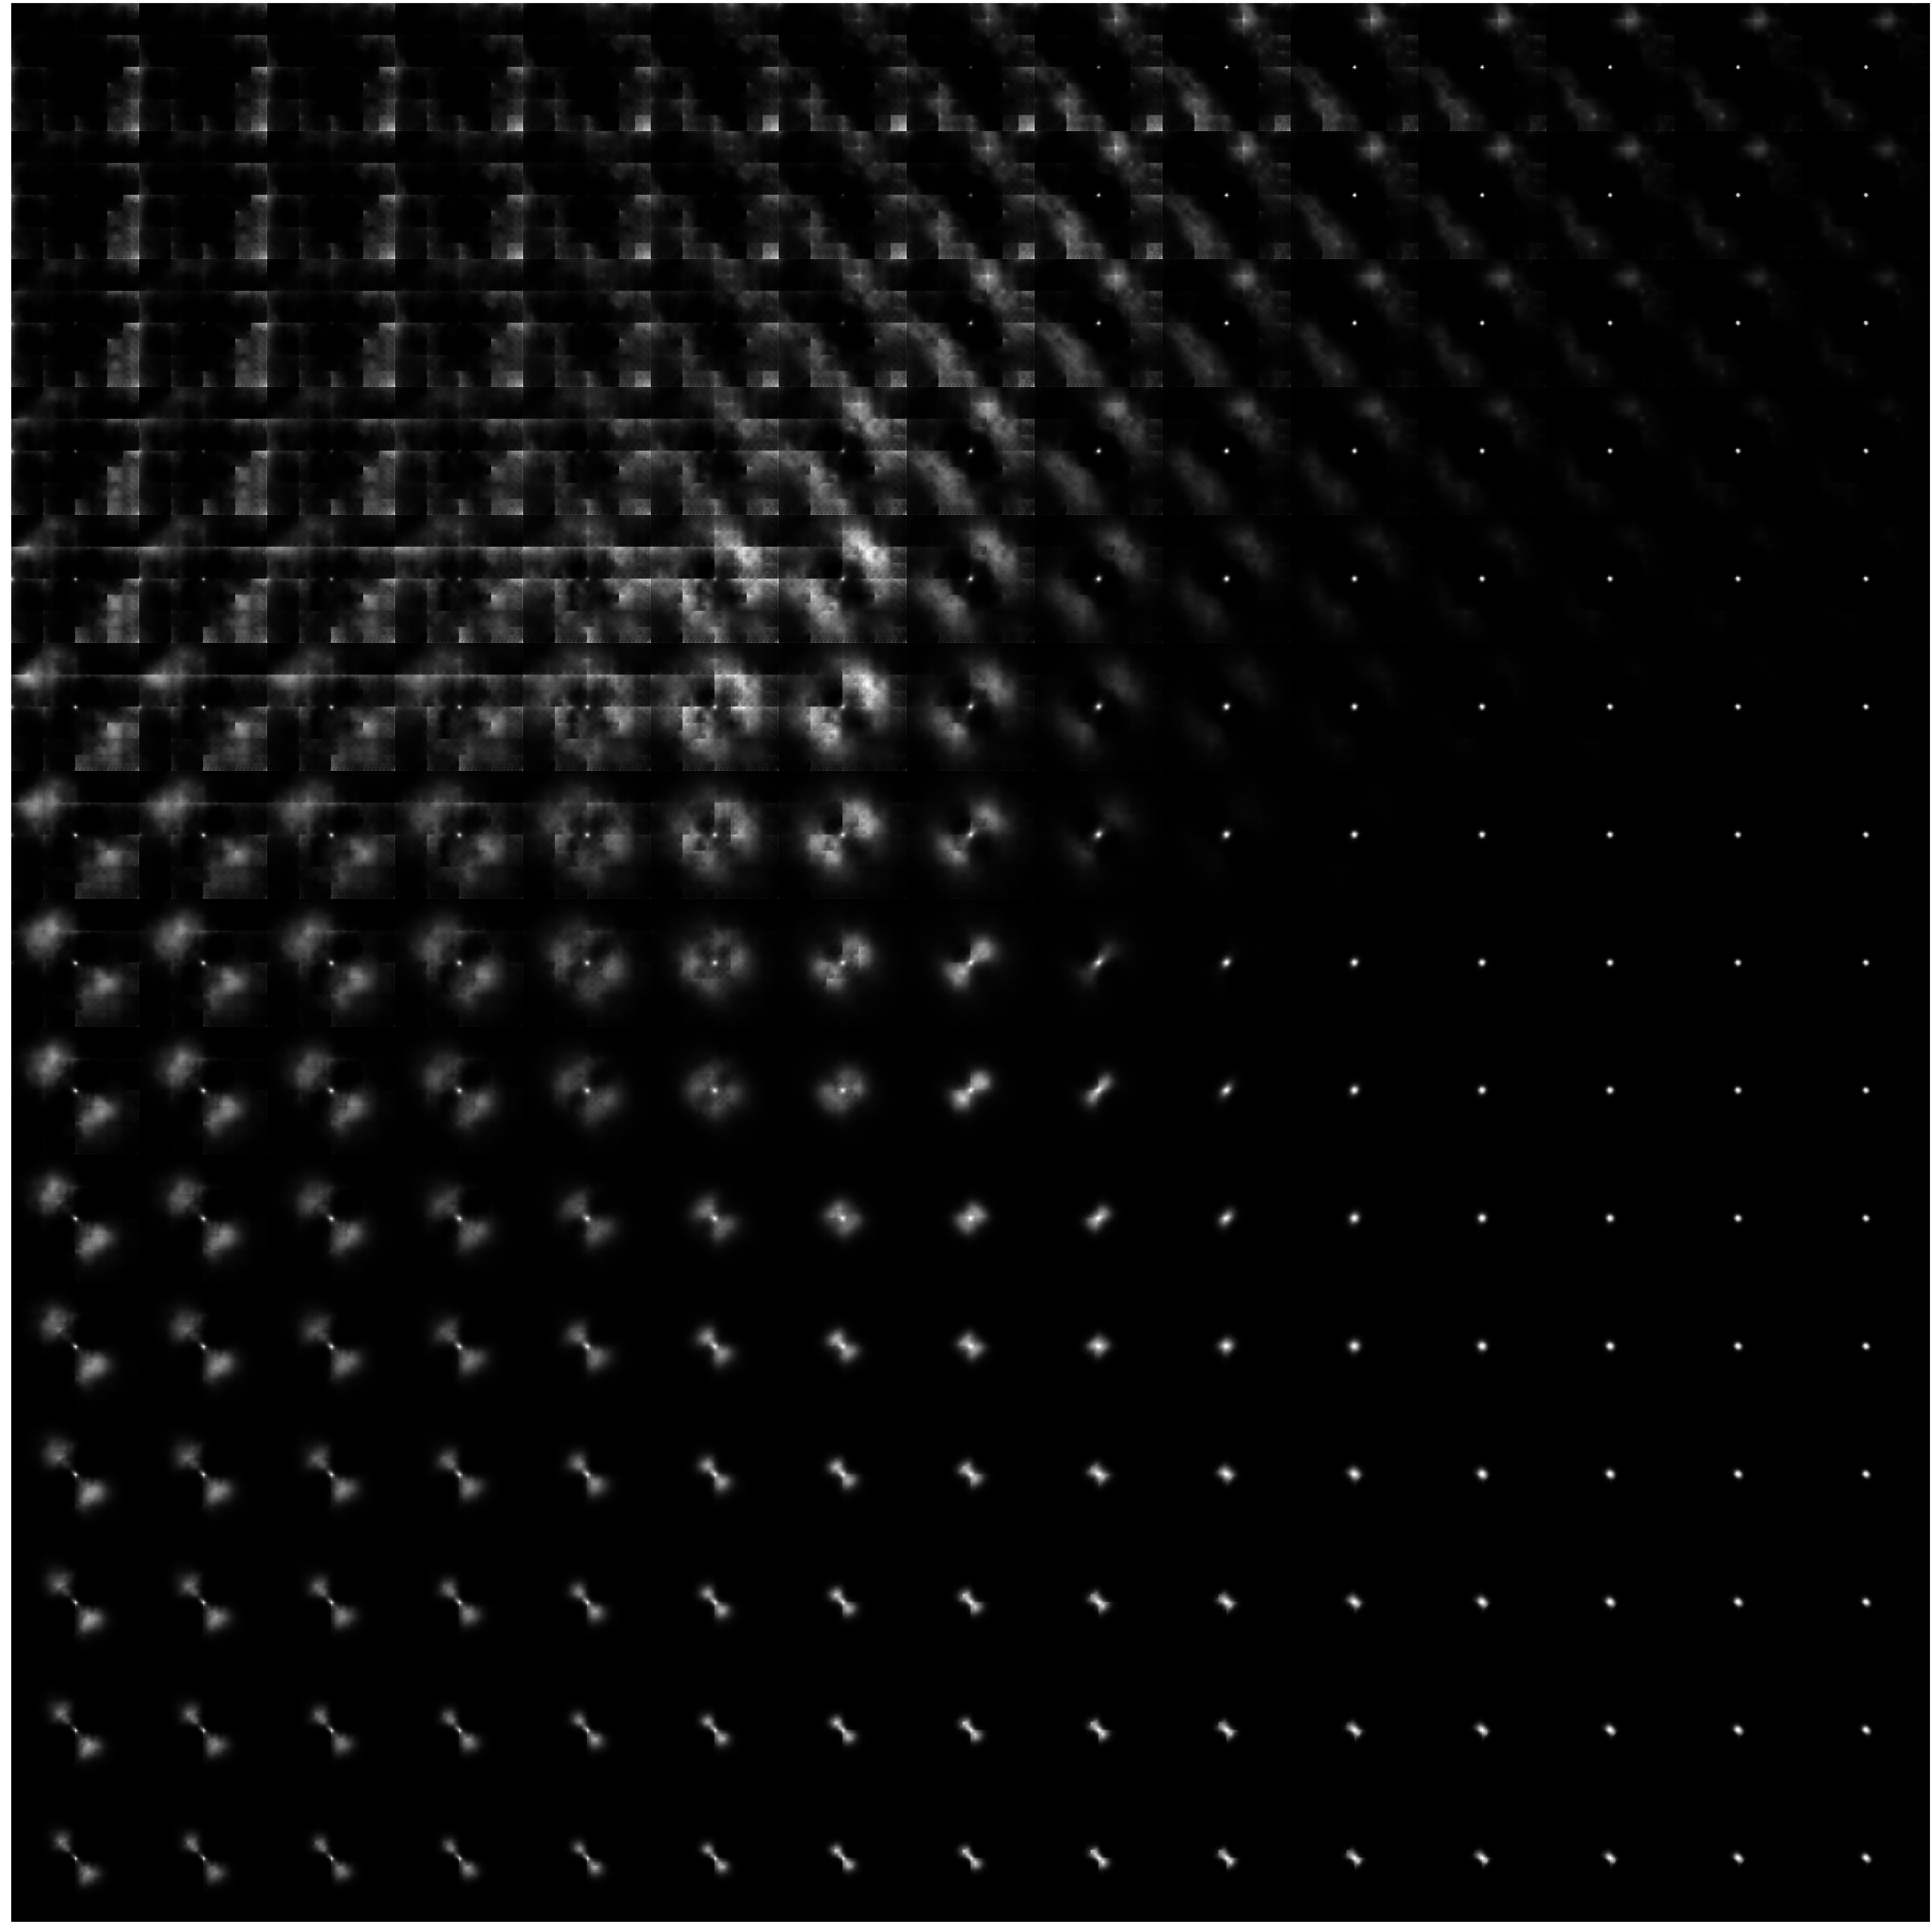

In [195]:
r = 15
nimg = r * 15

plt.figure(figsize=(101.3, 104))
gs1 = gridspec.GridSpec(15, r)
gs1.update(wspace=0, hspace=0)

for i in range(15):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = torch.Tensor([-5 + j, -5 + i]).cuda()
            d = cae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')